In [1]:
import operator, json
from typing import Annotated, Sequence
from typing_extensions import TypedDict
from langchain_core.messages import BaseMessage
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_core.tools import tool
from langchain_community.tools.tavily_search import TavilySearchResults

In [2]:
from langchain_groq import ChatGroq
import os

groq_api_key = os.getenv('GROQ_API_KEY')

llm = ChatGroq(groq_api_key=groq_api_key, model="qwen-qwq-32b")
# qwen-qwq-32b
# llama-3.3-70b-versatile

In [3]:
@tool
def search(query: str):
    "Perform web search on user query"
    tavily = TavilySearchResults()
    result = tavily.invoke(query)
    return result

In [4]:
@tool
def multiply(a:int, b:int) -> int:
    """multiply a and b"""
    return a*b

In [5]:
search.invoke("who is prime minister of India?")

[{'url': 'https://en.wikipedia.org/wiki/Prime_Minister_of_India',
  'content': "From Wikipedia, the free encyclopedia\nHead of government of India\nFor a list of prime ministers, see List of prime ministers of India.\n| Prime Minister of India |\n| --- |\n| Bhārata kē Pradhānamantrī |\n| \nLogo of the Prime Minister of India\n|\n| \nFlag of India\n|\n| \n\nIncumbent\nNarendra Modi \nsince\xa026 May 2014\n|\n| Prime Minister's Office\nUnion Council of Ministers\nExecutive branch of the Indian Government |\n| Style | \n\nThe Honourable\nMr. Prime Minister (informal)\nHis Excellency (diplomatic) [...] Rao, Atal Bihari Vajpayee, Manmohan Singh, and Narendra Modi. Modi is the current prime minister of India, serving since 26 May 2014 and the first to win three consecutive elections to secure a third successive term , 2014 , 2019 ,2024 [...] External links\n\nWikimedia Commons has media related to Prime Minister of India.\n| \n*   v\n*   t\n*   e\nPrime Minister of India\n|\n| --- |\n| \n\nL

In [6]:
tools = [search, multiply]

In [7]:
llm_with_tool = llm.bind_tools(tools)

In [8]:
llm_with_tool.invoke("who is the president of Japan").tool_calls

[{'name': 'search',
  'args': {'query': 'who is the president of Japan'},
  'id': 'call_0gkv',
  'type': 'tool_call'}]

In [9]:
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]

In [10]:
def invoke_model(state: AgentState):
    message = state['messages']
    question = message[-1]
    return {"messages": [llm_with_tool.invoke(question)]}

In [11]:
tool_mapping = {tool.name: tool for tool in tools}

In [12]:
tool_mapping

{'search': StructuredTool(name='search', description='Perform web search on user query', args_schema=<class 'langchain_core.utils.pydantic.search'>, func=<function search at 0x00000203F6DD7880>),
 'multiply': StructuredTool(name='multiply', description='multiply a and b', args_schema=<class 'langchain_core.utils.pydantic.multiply'>, func=<function multiply at 0x00000203F6DD7B00>)}

In [13]:
response = llm_with_tool.invoke("who is current president in uk?")

In [14]:
response

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_qwwh', 'function': {'arguments': '{"query": "who is the current president of the UK?"}', 'name': 'search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 227, 'prompt_tokens': 219, 'total_tokens': 446, 'completion_time': 0.511590385, 'prompt_time': 0.013152566, 'queue_time': 0.304094484, 'total_time': 0.524742951}, 'model_name': 'qwen-qwq-32b', 'system_fingerprint': 'fp_07cd5d759a', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-23c80a42-33fb-4be6-9b44-155703426309-0', tool_calls=[{'name': 'search', 'args': {'query': 'who is the current president of the UK?'}, 'id': 'call_qwwh', 'type': 'tool_call'}], usage_metadata={'input_tokens': 219, 'output_tokens': 227, 'total_tokens': 446})

In [15]:
tool_details = response.additional_kwargs

In [16]:
tool_details

{'tool_calls': [{'id': 'call_qwwh',
   'function': {'arguments': '{"query": "who is the current president of the UK?"}',
    'name': 'search'},
   'type': 'function'}]}

In [17]:
tool_details = tool_details.get("tool_calls")
tool_details

[{'id': 'call_qwwh',
  'function': {'arguments': '{"query": "who is the current president of the UK?"}',
   'name': 'search'},
  'type': 'function'}]

In [18]:
tool_details[0]['function']['name']

'search'

In [19]:
tool_details[0].get('function').get('arguments')

'{"query": "who is the current president of the UK?"}'

In [20]:
# converted string to json
json.loads(tool_details[0].get('function').get('arguments'))

{'query': 'who is the current president of the UK?'}

In [21]:
tool_mapping[tool_details[0]['function']['name']].invoke(json.loads(tool_details[0]['function']['arguments']))

[{'url': 'https://en.wikipedia.org/wiki/Rishi_Sunak',
  'content': '1965Heath1975Thatcher1989Thatcher re-elected1990Major1995Major re-elected1997Hague2001Duncan Smith2003Howard2005Cameron2016May2019JohnsonJuly–September 2022TrussOctober 2022Sunak2024Badenoch [...] 1965Heath1975Thatcher1989Thatcher re-elected1990Major1995Major re-elected1997Hague2001Duncan Smith2003Howard2005Cameron2016May2019JohnsonJuly–September 2022TrussOctober 2022Sunak2024Badenoch [...] ChamberlainWinston ChurchillSir Anthony EdenHarold MacmillanSir Alec Douglas-HomeEdward HeathMargaret ThatcherJohn MajorWilliam HagueIain Duncan SmithMichael HowardDavid CameronTheresa MayBoris JohnsonLiz TrussRishi SunakKemi BadenochvteLeaders of the opposition of the United KingdomHouse of CommonsFoxHowickPonsonbyTierneyPeelAlthorpPeelRussellPeelRussellBentinckGranbyGranby/Herries/DisraeliDisraeliRussellDisraeliPalmerstonDisraeliGladstoneDisraeliGladstoneHartingtonNorthcoteGladstoneHicks'},
 {'url': 'https://en.wikipedia.org/wiki/

In [22]:
def invoke_tool(state: AgentState):
    tool_details = state['messages'][-1].additional_kwargs.get("tool_calls", [])[0]
    
    if tool_details is None:
        raise Exception("no tool call found")
    
    print()
    
    if tool_details.get("function").get("name") == "search":
        response = input(prompt=f"[y/n] continue with expensive websearch")
        if response == 'n':
            raise Exception("web search discarded")
        response = tool_mapping[tool_details['function']['name']].invoke(json.loads(tool_details.get('function').get('arguments')))
    return {"messages": [response]}

In [23]:
def router(state: AgentState):
    tool_calls = state['messages'][-1].additional_kwargs.get("tool_calls", [])
    if len(tool_calls):
        return "tool"
    return "end"
    

In [24]:
graph = StateGraph(AgentState)

graph.add_node("ai_assistant", invoke_model)
graph.add_node("tool", invoke_tool)

graph.add_conditional_edges("ai_assistant",
                            router,
                            {
                                "tool": "tool",
                                "end": END
                            }
                            )

graph.set_entry_point("ai_assistant")
graph.add_edge("tool", END)

app = graph.compile()

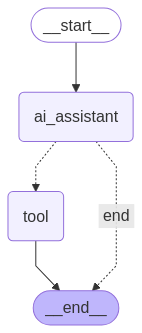

In [25]:
from IPython.display import display, Image

display(Image(app.get_graph().draw_mermaid_png()))

In [26]:
query = {"messages": ["who is upcoming president of USA?"]}

In [27]:
app.invoke(query)

{'messages': ['who is upcoming president of USA?',
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_2jxk', 'function': {'arguments': '{"query": "upcoming US presidential election 2024 candidates"}', 'name': 'search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 214, 'prompt_tokens': 219, 'total_tokens': 433, 'completion_time': 0.519715246, 'prompt_time': 0.012176459, 'queue_time': 0.246089823, 'total_time': 0.531891705}, 'model_name': 'qwen-qwq-32b', 'system_fingerprint': 'fp_512a3da6bb', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-2ce0ca24-a442-42a1-b672-7fe1e94a6a51-0', tool_calls=[{'name': 'search', 'args': {'query': 'upcoming US presidential election 2024 candidates'}, 'id': 'call_2jxk', 'type': 'tool_call'}], usage_metadata={'input_tokens': 219, 'output_tokens': 214, 'total_tokens': 433}),
  [{'url': 'https://ballotpedia.org/Presidential_candidates,_2024',
    'content': "2024 Presidential ElectionDate:November

In [28]:
# for s in app.stream({"messages": ["who is upcoming president of USA?"]}):
#     print(list(s.values())[0])
#     print("---")

In [29]:
# query = {"messages": ["what is multiplication of 34 and 33"]}
# app.invoke(query)

In [30]:
# query = {"messages": ["what is todays match score"]}
# app.invoke(query)

# Memory

In [31]:
tavily = TavilySearchResults()

In [32]:
tools = [tavily]

In [33]:
llm_with_tool = llm.bind_tools(tools)

In [104]:
def ai_assistant(state: AgentState):
    return {"messages": [llm_with_tool.invoke(state["messages"])]}

In [105]:
memory = MemorySaver()

In [106]:
graph_builder = StateGraph(AgentState)

graph_builder.add_node("ai_assistant", ai_assistant)
graph_builder.add_node("tools", ToolNode(tools))

graph_builder.add_edge(START, "ai_assistant")
graph_builder.add_conditional_edges(
    "ai_assistant",
    tools_condition
)

graph_builder.add_edge("tools", "ai_assistant")

app2 = graph_builder.compile(checkpointer=memory,
                             interrupt_before=["tools"]
                             )

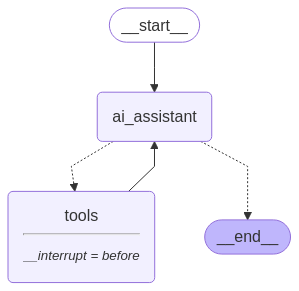

In [107]:
display(Image(app2.get_graph().draw_mermaid_png()))

In [92]:
user_input  = "what is current capital of india?"

config = {"configurable": {"thread_id": 1}}

In [63]:
user_input  = "what is the todays value of apple stock"

config = {"configurable": {"thread_id": 1}}

In [108]:
user_input  = "famous places of the Bengalore and must visit restaurants?"

config = {"configurable": {"thread_id": 1}}

In [109]:
events = app2.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)

In [110]:
for event in events:
    print(event)

{'messages': [('user', 'famous places of the Bengalore and must visit restaurants?')]}
{'messages': [('user', 'famous places of the Bengalore and must visit restaurants?'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_vstg', 'function': {'arguments': '{"query": "Top famous tourist attractions in Bangalore 2024"}', 'name': 'tavaly_search_results_json'}, 'type': 'function'}, {'id': 'call_tbj3', 'function': {'arguments': '{"query": "Best must-try restaurants in Bangalore for dining 2024"}', 'name': 'tavaly_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 234, 'prompt_tokens': 398, 'total_tokens': 632, 'completion_time': 0.529249167, 'prompt_time': 0.065416793, 'queue_time': -0.8212182210000001, 'total_time': 0.59466596}, 'model_name': 'qwen-qwq-32b', 'system_fingerprint': 'fp_07cd5d759a', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-a90a2285-f1c3-4a0f-92cc-0aef4e755ef2-0', tool_calls=[{'name': 'taval

In [111]:
# for event in events:
#     if "messages" in event:
#         event['messages'][-1].pretty_print()

In [112]:
snapshot = app2.get_state(config=config)

In [113]:
snapshot.next

('tools',)

In [114]:
last_message = snapshot.values["messages"][-1]

In [115]:
last_message.tool_calls

[{'name': 'tavaly_search_results_json',
  'args': {'query': 'Top famous tourist attractions in Bangalore 2024'},
  'id': 'call_vstg',
  'type': 'tool_call'},
 {'name': 'tavaly_search_results_json',
  'args': {'query': 'Best must-try restaurants in Bangalore for dining 2024'},
  'id': 'call_tbj3',
  'type': 'tool_call'}]

In [116]:
events = app2.stream(None, config, stream_mode="values")

In [117]:
for event in events:
    if "messages" in event:
        event['messages'][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  tavaly_search_results_json (call_vstg)
 Call ID: call_vstg
  Args:
    query: Top famous tourist attractions in Bangalore 2024
  tavaly_search_results_json (call_tbj3)
 Call ID: call_tbj3
  Args:
    query: Best must-try restaurants in Bangalore for dining 2024
================================= Tool Message =================================
Name: tavaly_search_results_json

Error: tavaly_search_results_json is not a valid tool, try one of [tavily_search_results_json].
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_xh4q)
 Call ID: call_xh4q
  Args:
    query: Top famous tourist attractions in Bangalore 2024
  tavily_search_results_json (call_rsgy)
 Call ID: call_rsgy
  Args:
    query: Best must-try restaurants in Bangalore for dining 2024


In [118]:
user_input = "What is a weather there?"

config = {"configurable": {"thread_id": "1"}}

In [121]:
events = app2.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)

In [122]:
for event in events:
    print(event)

{'messages': [['user', 'What is a weather there?'], AIMessage(content="I'll need the location to check the weather. Could you please specify where you want the weather information for?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 242, 'prompt_tokens': 193, 'total_tokens': 435, 'completion_time': 0.550340612, 'prompt_time': 0.017107411, 'queue_time': 0.33809370899999996, 'total_time': 0.567448023}, 'model_name': 'qwen-qwq-32b', 'system_fingerprint': 'fp_a91d9c2cfb', 'finish_reason': 'stop', 'logprobs': None}, id='run-9104717d-0016-4f44-86a7-590d88fc274e-0', usage_metadata={'input_tokens': 193, 'output_tokens': 242, 'total_tokens': 435}), ('user', 'What is a weather there?')]}
{'messages': [['user', 'What is a weather there?'], AIMessage(content="I'll need the location to check the weather. Could you please specify where you want the weather information for?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 242, 'prompt_tok

In [123]:
snapshot = app2.get_state(config)

In [124]:
snapshot.next

()

In [125]:
last_message = snapshot.values['messages'][-1]

In [127]:
last_message.tool_calls

[]

In [128]:
events = app2.stream(None, config, stream_mode="values")

In [129]:
for event in events:
    if "messages" in event:
        event['messages'][-1].pretty_print()

================================== Ai Message ==================================

I'll need the location to check the weather. Could you please specify which place you're asking about?


#### Fetch the complete details

In [130]:
app2.get_state(config)

StateSnapshot(values={'messages': [['user', 'What is a weather there?'], AIMessage(content="I'll need the location to check the weather. Could you please specify where you want the weather information for?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 242, 'prompt_tokens': 193, 'total_tokens': 435, 'completion_time': 0.550340612, 'prompt_time': 0.017107411, 'queue_time': 0.33809370899999996, 'total_time': 0.567448023}, 'model_name': 'qwen-qwq-32b', 'system_fingerprint': 'fp_a91d9c2cfb', 'finish_reason': 'stop', 'logprobs': None}, id='run-9104717d-0016-4f44-86a7-590d88fc274e-0', usage_metadata={'input_tokens': 193, 'output_tokens': 242, 'total_tokens': 435}), ['user', 'What is a weather there?'], AIMessage(content="I'll need the location to check the weather. Could you please specify which place you're asking about?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 199, 'prompt_tokens': 231, 'total_tokens': 430, 'completion

In [131]:
snapshot = app2.get_state(config)

In [132]:
snapshot.next

()

In [133]:
user_input = "give me the recent news from there?"

config = {"configurable": {"thread_id": "1"}}

In [134]:
events = app2.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)

In [135]:
for event in events:
    if "messages" in event:
        event['messages'][-1].pretty_print()

AttributeError: 'tuple' object has no attribute 'pretty_print'

In [136]:
snapshot = app2.get_state(config)

In [140]:
current_message = snapshot.values["messages"]

In [141]:
current_message

[['user', 'What is a weather there?'],
 AIMessage(content="I'll need the location to check the weather. Could you please specify where you want the weather information for?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 242, 'prompt_tokens': 193, 'total_tokens': 435, 'completion_time': 0.550340612, 'prompt_time': 0.017107411, 'queue_time': 0.33809370899999996, 'total_time': 0.567448023}, 'model_name': 'qwen-qwq-32b', 'system_fingerprint': 'fp_a91d9c2cfb', 'finish_reason': 'stop', 'logprobs': None}, id='run-9104717d-0016-4f44-86a7-590d88fc274e-0', usage_metadata={'input_tokens': 193, 'output_tokens': 242, 'total_tokens': 435}),
 ['user', 'What is a weather there?'],
 AIMessage(content="I'll need the location to check the weather. Could you please specify which place you're asking about?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 199, 'prompt_tokens': 231, 'total_tokens': 430, 'completion_time': 0.485638352, 'prompt_ti

In [142]:
tool_call_id = current_message.tool_calls[0]["id"]

AttributeError: 'list' object has no attribute 'tool_calls'

In [143]:
from langchain_core.messages import AIMessage, ToolMessage

In [144]:
answer = "delhi is too hot now a days as well as bit foggy"

In [ ]:
new_message = [
    ToolMessage(content=answer, tool_call_id=tool_call_id),
    AIMessage(content=answer),
]

In [ ]:
app2.update_state(
    config,
    {"messages": new_message}
)

In [ ]:
print(app2.get_state(config).values['messages'][-1:])